In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import utils
import eval

from model.stgcn import flow_stgcn
from model.st_graph import get_distance_adjacency
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

In [3]:
edges = [
    [0, 1],  # Nose - Left Eye
    [0, 2],  # Nose - Right Eye
    [1, 3],  # Left Eye - Left Ear
    [2, 4],  # Right Eye - Right Ear
    [1, 5],  # Left Eye - Left Shoulder
    [2, 6],  # Right Eye - Right Shoulder
    [5, 7],  # Left Shoulder - Left Elbow
    [6, 8],  # Right Shoulder - Right Elbow
    [7, 9],  # Left Elbow - Left Wrist
    [8, 10],  # Right Elbow - Right Wrist
    [5, 11],  # Left Shoulder - Left Hip
    [6, 12],  # Right Shoulder - Right Hip
    [11, 13],  # Left Hip - Left Knee
    [12, 14],  # Right Hip - Right Knee
    [13, 15],  # Left Knee - Left Ankle
    [14, 16]   # Right Knee - Right Ankle
]

# Load the Le2i Coffe Room and Home

In [13]:
# dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'frame_ids', 'flows', 'offset', 'fall_interval'])
coffee_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\falls.npy", allow_pickle=True)
coffee_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\non_falls.npy", allow_pickle=True)
home_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\falls.npy", allow_pickle=True)
home_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\non_falls.npy", allow_pickle=True)

In [14]:
c_fall_train, c_fall_test = train_test_split(coffee_falls, test_size=0.2)
c_nfall_train, c_nfall_test = train_test_split(coffee_non_falls, test_size=0.2)
h_fall_train, h_fall_test = train_test_split(home_falls, test_size=0.2)
h_nfall_train, h_nfall_test = train_test_split(home_non_falls, test_size=0.2)

c_test = [('coffee_room ' + data['filename'], data['keypoints'], data['flows'], data['frame_ids']) for data in c_fall_test.tolist()] + [('coffee_room ' + data['filename'], data['keypoints'], data['flows'], data['frame_ids']) for data in c_nfall_test.tolist()]
h_test = [('home ' + data['filename'], data['keypoints'], data['flows'], data['frame_ids']) for data in h_fall_test.tolist()] + [('home ' + data['filename'], data['keypoints'], data['flows'], data['frame_ids']) for data in h_nfall_test.tolist()]
test_data = c_test + h_test
test_labels = np.concatenate((np.ones(len(c_fall_test)), np.zeros(len(c_nfall_test)), np.ones(len(h_fall_test)), np.zeros(len(h_nfall_test))))

In [35]:
falls = []
non_falls = []

train_falls, train_non_falls = utils.split_skeletons_and_flows(c_fall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons_and_flows(c_nfall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons_and_flows(h_fall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons_and_flows(h_nfall_train)
falls += train_falls
non_falls += train_non_falls

X_falls = np.array([data['skeletons'] for data in falls])
X_non_falls = np.array([data['skeletons'] for data in non_falls])
X_falls_flow = np.array([data['flows'] for data in falls])
X_non_falls_flow = np.array([data['flows'] for data in non_falls])

X_falls = X_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates
X_non_falls = X_non_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates

In [36]:
# normalize the data using the max values in the dataset
# the original coordinates is stored as (x, y)
# Le2i resolution is 320x240

max_x = 320
max_y = 240

X_falls[:, :, :, 0] /= max_x
X_falls[:, :, :, 1] /= max_y
X_non_falls[:, :, :, 0] /= max_x
X_non_falls[:, :, :, 1] /= max_y
X_falls = np.transpose(X_falls, (0, 3, 1, 2))
X_non_falls = np.transpose(X_non_falls, (0, 3, 1, 2))
X_falls_flow = np.transpose(X_falls_flow, (0, 2, 1))
X_non_falls_flow = np.transpose(X_non_falls_flow, (0, 2, 1))

print(X_falls.shape, X_non_falls.shape, X_falls_flow.shape, X_non_falls_flow.shape)

(78, 2, 45, 17) (699, 2, 45, 17) (78, 64, 45) (699, 64, 45)


# Initialize the model and dataset object

In [37]:
num_node = 17
A = get_distance_adjacency(np.array(edges), num_node)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
class FlowFallDataset(Dataset):
    def __init__(self, falls, non_falls, falls_flow, non_falls_flow):
        self.falls = falls
        self.non_falls = non_falls
        self.falls_flow = falls_flow
        self.non_falls_flow = non_falls_flow

    def __len__(self):
        # The dataset length is twice the length of the smaller list
        return len(self.falls) + len(self.non_falls)

    def __getitem__(self, idx):
        if idx < len(self.falls):
            return self.falls[idx], self.falls_flow[idx], 1.0
        else:
            return self.non_falls[idx - len(self.falls)], self.non_falls_flow[idx - len(self.falls)], 0.0

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset):
        self.num_falls = len(dataset.falls)
        self.num_non_falls = len(dataset.non_falls)
        self.data_size = self.num_falls + self.num_non_falls
        self.batch_size = 2 * self.num_falls

    def __iter__(self):
        # Create an array of indices representing balanced classes
        non_fall_indices = np.arange(self.num_non_falls)
        np.random.shuffle(non_fall_indices)  # Shuffle the indices to have random batches
        batch = np.arange(self.num_falls).tolist()
        for idx in non_fall_indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = np.arange(self.num_falls).tolist()
        if len(batch) > 0:  # Yield remaining items not fitting into a full batch
            yield batch

    def __len__(self):
        return (self.data_size + self.batch_size - 1) // self.batch_size

def evaluate(model, loader, print_acc=False):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    acc, loss = 0.0, 0.0
    for X_batch, flow_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        flow_batch = flow_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)
        with torch.no_grad():
            y_pred = model(X_batch, flow_batch)
            loss += loss_func(y_pred, y_batch).detach().cpu().item()
            acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
            
    loss /= len(loader.dataset)
    acc /= len(loader.dataset)
    return loss, acc

In [55]:
class Trainer:
    def __init__(self, model, opt_method, lr, batch_size, epochs, weight_decay=0, momentum=0) -> None:
        self.model = model
        self.model.to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
    
    def train(self, training_set, validation_set, early_stop=False):
        loss_func = nn.CrossEntropyLoss()
        training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
        train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
        validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []

        progress = tqdm(np.arange(self.epochs))
        for n in progress:
            self.model.train()
            for X_batch, flow_batch, y_batch in training_loader:
                X_batch = X_batch.to(device)
                flow_batch = flow_batch.to(device)
                y_batch = y_batch.type(torch.LongTensor).to(device)

                y_pred = self.model(X_batch, flow_batch)
                batch_loss = loss_func(y_pred, y_batch)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

            train_loss, train_acc = evaluate(self.model, train_eval_loader)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)

            val_loss, val_acc = evaluate(self.model, validation_loader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            progress.set_description(f'Training Loss: {train_loss:.4f}')

        x_axis = np.arange(self.epochs)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(x_axis, train_loss_list, label="Training")
        axes[0].plot(x_axis, val_loss_list, label="Validation")
        axes[0].set_title("Loss")
        axes[0].set_xlabel('Epoch')
        axes[0].legend()
        axes[1].plot(x_axis, train_acc_list, label='Training')
        axes[1].plot(x_axis, val_acc_list, label='Validation')
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel('Epoch')
        axes[1].legend()

        print(f"Training loss: {train_loss_list[-1]}")
        print(f"Validation loss: {val_loss_list[-1]}")
        print(f"Training accuracy: {train_acc_list[-1]}")
        print(f"Validation accuracy: {val_acc_list[-1]}")
        
        return {'train_loss': train_acc_list, 'val_loss': val_loss_list, 'train_acc': train_acc_list, 'val_acc': val_acc_list}
    
    def evaluate(self, loader):
        self.model.eval()
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, flow_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            flow_batch = flow_batch.to(device)
            y_batch = y_batch.type(torch.LongTensor).to(device)
            with torch.no_grad():
                y_pred = self.model(X_batch, flow_batch)
                loss += loss_func(y_pred, y_batch).detach().cpu().item()
                acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
                
        loss /= len(loader.dataset)
        acc /= len(loader.dataset)
        return loss, acc

def KFoldCrossValidation(
    model_class, k,
    X_falls, X_non_falls, X_test, y_test,
    opt_method='adam', lr=1e-3, batch_size=128, epochs=50, weight_decay=0.0,
    early_break=False,
    **model_args
 ):
    test_set = (X_test, y_test)
    
    # Setting up two KFold instances
    kf_falls = KFold(n_splits=k, shuffle=True)
    kf_non_falls = KFold(n_splits=k, shuffle=True)

    train_acc_list, val_acc_list, test_acc_list = [], [], []
    for i, ((train_idx_f, valid_idx_f), (train_idx_nf, valid_idx_nf)) in enumerate(zip(kf_falls.split(X_falls), kf_non_falls.split(X_non_falls))):
        print(f"Fold {i}:")
        model = model_class(**model_args)
        trainer = Trainer(model, opt_method, lr, batch_size, epochs, weight_decay=weight_decay, momentum=0)
        training_set = FlowFallDataset(falls=X_falls[train_idx_f], non_falls=X_non_falls[train_idx_nf])
        validation_set = FlowFallDataset(falls=X_falls[valid_idx_f], non_falls=X_non_falls[valid_idx_nf])
        res = trainer.train(training_set, validation_set)
        train_acc_best = np.max(res['train_acc'])
        val_acc_best = np.max(res['val_acc'])
        test_acc, test_results = eval.evaluate(model, device, testset=test_set, profile=False)
        train_acc_list.append(train_acc_best)
        val_acc_list.append(val_acc_best)
        test_acc_list.append(test_acc)
        print(f"Best training accuracy: {train_acc_best}")
        print(f"Best validation accuracy: {val_acc_best}")
        print(f"Test accuracy: {test_acc}")
        if early_break:
            break
        
    if not early_break:
        print("Final results:")
        print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
        print(f"Validation accuracy: {np.mean(val_acc_list)}+/-{np.std(val_acc_list)}")
        print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")

# Training loop

In [104]:
layer_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]
default_layer_config = [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                        (128, 128, 1), (128, 256, 2), (256, 256, 1), (256, 256, 1)] # (in_channles, out_channels, temporal_stride)
my_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]

Training Loss: 0.0050: 100%|██████████| 35/35 [02:21<00:00,  4.05s/it]

Training loss: 0.005016497397582803
Validation loss: 0.014344768598675728
Training accuracy: 0.8469798657718121
Validation accuracy: 0.84375


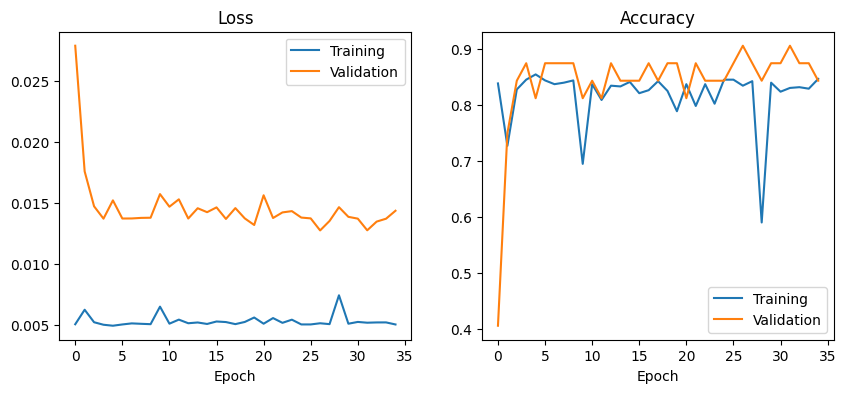

In [115]:
model = None
model = flow_stgcn(num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config, learnable_mask=True, flow_norm=True)
model.to(device)

falls_train, falls_valid = train_test_split(X_falls, test_size=0.2)
falls_flow_train, falls_flow_valid = train_test_split(X_falls_flow, test_size=0.2)
non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid))
non_falls_flow_train, non_falls_flow_valid = train_test_split(X_non_falls_flow, test_size=len(falls_valid))
training_set = FlowFallDataset(falls=falls_train, non_falls=non_falls_train, falls_flow=falls_flow_train, non_falls_flow=non_falls_flow_train)
validation_set = FlowFallDataset(falls=falls_valid, non_falls=non_falls_valid, falls_flow=falls_flow_valid, non_falls_flow=non_falls_flow_valid)


epochs = 35
lr = 0.001
weight_decay = 0
batch_size = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    for X_batch, flow_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        flow_batch = flow_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch, flow_batch)
        batch_loss = loss_func(y_pred, y_batch)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    train_loss, train_acc = evaluate(model, train_eval_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Training')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].legend()

print(f"Training loss: {train_loss_list[-1]}")
print(f"Validation loss: {val_loss_list[-1]}")
print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

In [116]:
acc, results = eval.evaluate_flow(model, device, testset=([data[:4] for data in test_data], test_labels), profile=True)

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]

False positives: ['coffee_room video (69)', 'home video (59)', 'home video (41)']
False negatives: ['coffee_room video (13)']
Accuracy: 0.8571428571428571


# Test on unseen data

In [100]:
LEC_ROOM_DIR = "D:\ASH\datasets\Le2i-skeleton\Lecture room\Skeletons_full"
OFFICE_DIR = "D:\ASH\datasets\Le2i-skeleton\Office\Skeletons_full"
LEC_ROOM_FLOWS_DIR = "D:\ASH\datasets\Le2i-skeleton\Lecture room\Flows"
OFFICE_FLOWS_DIR = "D:\ASH\datasets\Le2i-skeleton\Office\Flows"

lec_room = eval.load_data(LEC_ROOM_DIR, LEC_ROOM_FLOWS_DIR)
lec_room = [('lec_room ' + data[0], data[1], data[2], data[3]) for data in lec_room]
    
office = eval.load_data(OFFICE_DIR, OFFICE_FLOWS_DIR)
office = [('office ' + data[0], data[1], data[2], data[3]) for data in office]

In [101]:
unseen_test_data = lec_room + office
unseen_test_labels = eval.LEC_ROOM_LABELS + eval.OFFICE_LABELS

In [113]:
state_dict = torch.load("D:\ASH\\auto-senior-care-system\st-gcn\model_weights\le2i_flow_97acc.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [117]:
stride = 1
test_acc, test_results = eval.evaluate_flow(model, device, testset=([data[:4] for data in unseen_test_data], unseen_test_labels), profile=True, stride=stride)

100%|██████████| 60/60 [00:20<00:00,  2.89it/s]

False positives: ['lec_room video (16)', 'lec_room video (17)', 'lec_room video (19)', 'lec_room video (21)', 'lec_room video (22)', 'lec_room video (23)', 'lec_room video (24)', 'lec_room video (25)', 'lec_room video (26)', 'lec_room video (27)', 'office video (19)', 'office video (20)', 'office video (22)', 'office video (23)', 'office video (25)', 'office video (30)']
False negatives: ['office video (13)']
Accuracy: 0.7166666666666667


In [121]:
sample = unseen_test_data[21]
# sample = test_data[1]

skeleton_batch, flow_batch = eval.create_batch_flow(sample[1], sample[2], sample[3])
print(sample[0])

lec_room video (22)


# Visualization

In [123]:
import time

In [126]:
filename, skeletons, flows, frame_ids = unseen_test_data[20]
print(filename)
start_time = time.time()
skeleton_batch, flow_batch = eval.create_batch_flow(skeletons, flows, frame_ids)
model.eval()
with torch.no_grad():
    skeleton_batch = torch.tensor(skeleton_batch).to(device)
    flow_batch = torch.tensor(flow_batch).to(device)
    pred = model(skeleton_batch, flow_batch).cpu()
results = torch.argmax(pred, axis=-1).numpy()
runtime = time.time() - start_time
print(f"Inference time on {len(batch)} sub-sequences: {runtime}. The average time: {runtime / len(results)}")

lec_room video (21)
Inference time on 2 sub-sequences: 1.0219309329986572. The average time: 0.0011924514970812804


In [127]:
# This is an example, replace it with your video path
video_path = "D:\ASH\datasets\Le2i\Lecture room\Videos\\video (21).avi"
cap = cv2.VideoCapture(video_path)

output_video_path = 'output_video.avi'  # Path to save the output video
frame_width = 320  # Width of the frames in the video
frame_height = 240  # Height of the frames in the video
fps = 25  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_ptr = 0
curr_frame = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    position = (10, 10)  # Coordinates of the upper left corner
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    
    if frame_ptr < len(frame_ids) and frame_ids[frame_ptr] == curr_frame:
        pred_idx = frame_ptr - 45 + 1
        if pred_idx >= 0 and pred_idx < len(results):
            pred = results[pred_idx]
            if pred == 1:
                text = "Fall"
                font_color = (0, 0, 255)
            else:
                text = "No fall"
                font_color = (0, 255, 0)
            
        # Example joint coordinates for one person in the frame
        # Replace this with your actual detection data
        # Format: [x, y, confidence]
        joints = skeletons[frame_ptr]
        
        # Draw joints
        for joint in joints:
            # Convert coordinates to integers
            x, y = int(joint[0]), int(joint[1])
            cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)
        
        # Draw skeleton
        for bone in edges:
            # Convert coordinates to integers
            start_point, end_point = joints[bone[0]], joints[bone[1]]
            start_point = (int(start_point[0]), int(start_point[1]))
            end_point = (int(end_point[0]), int(end_point[1]))
            cv2.line(frame, start_point, end_point, (255, 0, 0), 2)
        
        frame_ptr += 1
    else:
        font_color = (255, 255, 255)
        text = "N/A"
    
    cv2.putText(frame, text, position, font, font_scale, font_color, thickness=2)

    # Display the frame with drawn joints and connections
    cv2.imshow('Frame', frame)
    out.write(frame)
    
    # if frame_ptr >= len(results): break 
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    
    curr_frame += 1

# Release everything if job is finished
out.release()
cap.release()
cv2.destroyAllWindows()